In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import functions as fn

In [2]:
# Read in the list of teams
teams = pd.read_csv('DataFiles/Teams.csv')
seasons_data = pd.read_csv('DataFiles/RegularSeasonDetailedResults.csv')
file_list = {}
years = ['18','17','16','15','14','13','12','11','10','09','08','07','06','05','04','03','02','01','00']

# Read in the data files from sports-reference.com
for s in years:
    filepath = ('WebData/ratings_' + s + '.csv')
    raw_data = pd.read_csv(filepath).drop(['Unnamed: 3', 'Unnamed: 9', 'Unnamed: 11'], axis=1)
    # We need only the school name and the rank
    raw_data = raw_data[['Rk', 'School']].dropna()
    raw_data = raw_data[(raw_data['Rk']).str.isnumeric()]
    file_list[s] = raw_data

In [3]:
# Extract the dataframes from the list
df_18 = file_list['18']
df_17 = file_list['17']
df_16 = file_list['16']
df_15 = file_list['15']
df_14 = file_list['14']
df_13 = file_list['13']
df_12 = file_list['12']
df_11 = file_list['11']
df_10 = file_list['10']
df_09 = file_list['09']
df_08 = file_list['08']
df_07 = file_list['07']
df_06 = file_list['06']
df_05 = file_list['05']
df_04 = file_list['04']
df_03 = file_list['03']
df_02 = file_list['02']
df_01 = file_list['01']
df_00 = file_list['00']
# Rename the columns
df_18.columns = ['2018', 'School']
df_17.columns = ['2017', 'School']
df_16.columns = ['2016', 'School']
df_15.columns = ['2015', 'School']
df_14.columns = ['2014', 'School']
df_13.columns = ['2013', 'School']
df_12.columns = ['2012', 'School']
df_11.columns = ['2011', 'School']
df_10.columns = ['2010', 'School']
df_09.columns = ['2009', 'School']
df_08.columns = ['2008', 'School']
df_07.columns = ['2007', 'School']
df_06.columns = ['2006', 'School']
df_05.columns = ['2005', 'School']
df_04.columns = ['2004', 'School']
df_03.columns = ['2003', 'School']
df_02.columns = ['2002', 'School']
df_01.columns = ['2001', 'School']
df_00.columns = ['2000', 'School']

In [4]:
# Merge the dataframes so that we can look at the correlation
from functools import reduce
data_frames = [df_18, df_17, df_16, df_15, df_14, df_13, df_12, df_11, df_10, df_09, df_08, 
               df_07, df_06, df_05, df_04, df_03, df_02, df_01, df_00]

team_ranks_df = reduce(lambda left, right: pd.merge(left, right, on=['School'], how='outer'), data_frames)

team_ranks_df = team_ranks_df.dropna().reset_index()

In [5]:
# Convert the rankings to integers
for col in team_ranks_df.columns:
    if str(col) != 'School':
        team_ranks_df[col] = team_ranks_df[col].astype(int)

In [6]:
# Look at the correlation between rankings for previous years
team_ranks_df.corr()

,index,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
index,1.000000,1.000000,0.853775,0.800106,0.776116,0.765266,0.717467,0.727487,0.728042,0.751906,0.724500,0.727779,0.736601,0.737438,0.708929,0.712824,0.736065,0.695705,0.652188,0.671007
2018,1.000000,1.000000,0.853775,0.800106,0.776116,0.765266,0.717467,0.727487,0.728042,0.751906,0.724500,0.727779,0.736601,0.737438,0.708929,0.712824,0.736065,0.695705,0.652188,0.671007
2017,0.853775,0.853775,1.000000,0.863033,0.795524,0.772686,0.741753,0.724426,0.752835,0.746708,0.698141,0.704452,0.732693,0.740122,0.726953,0.726111,0.734160,0.688553,0.667658,0.649043
2016,0.800106,0.800106,0.863033,1.000000,0.849893,0.812400,0.745885,0.732973,0.749500,0.749997,0.702338,0.695842,0.722092,0.715173,0.705352,0.718662,0.739638,0.709275,0.677314,0.663409
2015,0.776116,0.776116,0.795524,0.849893,1.000000,0.859217,0.769311,0.722072,0.740969,0.749037,0.706894,0.676928,0.704059,0.721554,0.717427,0.701016,0.732806,0.691640,0.680328,0.678004
2014,0.765266,0.765266,0.772686,0.812400,0.859217,1.000000,0.872070,0.797368,0.780917,0.779359,0.756674,0.710668,0.738638,0.754417,0.742758,0.745581,0.769304,0.719981,0.719876,0.697143
2013,0.717467,0.717467,0.741753,0.745885,0.769311,0.872070,1.000000,0.836685,0.775221,0.755315,0.732308,0.708333,0.716791,0.716586,0.701213,0.688042,0.711870,0.654986,0.655685,0.643252
2012,0.727487,0.727487,0.724426,0.732973,0.722072,0.797368,0.836685,1.000000,0.838347,0.774547,0.744379,0.711079,0.714381,0.717463,0.696717,0.705452,0.720682,0.683238,0.654667,0.652019
2011,0.728042,0.728042,0.752835,0.749500,0.740969,0.780917,0.775221,0.838347,1.000000,0.866801,0.805962,0.746923,0.763414,0.723135,0.717803,0.741336,0.730977,0.696127,0.684109,0.666555
2010,0.751906,0.751906,0.746708,0.749997,0.749037,0.779359,0.755315,0.774547,0.866801,1.000000,0.870194,0.785203,0.760530,0.746352,0.748245,0.757496,0.758366,0.707418,0.702970,0.690038


### We can see that the correlation with the 2018 rankings is slowly decreasing as we go back in time. For years prior to 2003, the correlation coefficient is less than 0.7.

In [7]:
team_ranks_df.to_csv('TeamRankings.csv')

In [8]:
rand_teams = np.random.randint(0, len(team_ranks_df.School), 6)
rand_teams

array([144, 254, 313, 114, 162, 107])

In [9]:
d1 = team_ranks_df.drop(['School'], axis=1).loc[132].values.astype(float)
d2 = team_ranks_df.drop(['School'], axis=1).loc[82].values.astype(float)
d3 = team_ranks_df.drop(['School'], axis=1).loc[175].values.astype(float)
d4 = team_ranks_df.drop(['School'], axis=1).loc[96].values.astype(float)
d5 = team_ranks_df.drop(['School'], axis=1).loc[295].values.astype(float)
d6 = team_ranks_df.drop(['School'], axis=1).loc[75].values.astype(float)

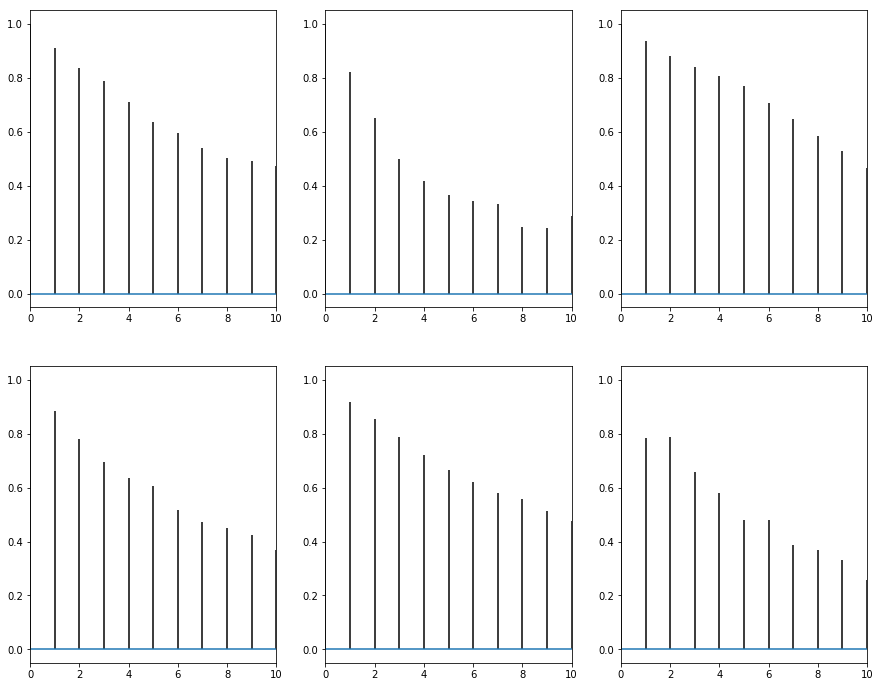

In [10]:
plt.figure(figsize=(15,12))
plt.subplot(2, 3, 1)
plt.xlim([0,10])
plt.acorr(d1)
plt.subplot(2, 3, 2)
plt.xlim([0,10])
plt.acorr(d2)
plt.subplot(2, 3, 3)
plt.xlim([0, 10])
plt.acorr(d3)
plt.subplot(2, 3, 4)
plt.xlim([0, 10])
plt.acorr(d4)
plt.subplot(2, 3, 5)
plt.xlim([0, 10])
plt.acorr(d5)
plt.subplot(2, 3, 6)
plt.xlim([0, 10])
plt.acorr(d6)

plt.savefig('autocorrelation_plot.png')
plt.show()

### From the autocorrelation plots, we can see that the rankings for the past 8 years have a fairly strong correlation with the current year for most teams.

In [11]:
# Look at the regular season data
#seasons_data[['Season', 'WTeamID', 'WOR']][0:30]
#seasons_data[seasons_data.WTeamID==1272][['WTeamID', 'Season', 'WOR']]
seasons_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [12]:
#Include only teams that have been Division I teams in the years included in the rankings data
teams = teams[teams.LastD1Season > 1999]

# Replace 'St' with 'State' in the TeamName column to correspond to the School column in the rest of the data
schools = []
for t in teams.TeamName:
    name = str(t)
    r_name = re.sub(' St', " State", name)
    schools.append(r_name)

teams.TeamName = schools
print(len(teams.TeamName.unique()))

357


In [13]:
# Create a dictionary with the team name and team id
teams_dict = {}

for i in teams.index:
    teams_dict[teams.TeamName[i]] = teams.TeamID[i]
    #teams_dict[teams.TeamID[i]] = teams.TeamName[i]
    
print(len(teams_dict))

357


In [14]:
# Create a list with the team ids
team_id_list = []

for i in team_ranks_df.index:
    s = str(team_ranks_df.School[i])
    if s in teams_dict:
        team_id = teams_dict[s]
        team_id_list.append(team_id)
    elif s not in teams_dict:
        team_id_list.append(np.nan)
        
team_ranks_df['TeamID'] = team_id_list

team_ranks_df = team_ranks_df.set_index('TeamID')
team_ranks_df.head()

,index,2018,School,2017,2016,2015,2014,2013,2012,2011,...,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
TeamID,,,,,,,,,,,,,,,,,,,,,
1437.0,0,1,Villanova,5,1,5,9,51,71,23,...,14,47,19,6,13,50,59,50,75,72
1181.0,1,2,Duke,9,12,2,6,4,12,2,...,6,5,11,2,3,1,6,1,1,2
1345.0,2,3,Purdue,15,9,34,71,64,24,8,...,18,31,27,145,87,51,22,67,28,24
1277.0,3,4,Michigan State,42,4,17,7,12,5,34,...,13,16,17,33,7,38,19,23,4,3
1438.0,4,5,Virginia,13,5,6,14,41,34,92,...,85,76,46,83,72,58,72,36,12,40


In [15]:
# Add a column with the team rank to seasons_data
w_rank_list = []
l_rank_list = []

for i in seasons_data.index:
    s = seasons_data.Season[i] # the year
    w = seasons_data.WTeamID[i] # winning team id
    l = seasons_data.LTeamID[i] # losing team id
    if w in team_ranks_df.index:
        w_rank = team_ranks_df.loc[w]
        w_rank_list.append(w_rank)
    elif w not in team_ranks_df.index:
        w_rank_list.append(np.nan)
        
    if l in team_ranks_df.index:
        l_rank = team_ranks_df.loc[l]
        l_rank_list.append(l_rank)
    elif l not in team_ranks_df.index:
        l_rank_list.append(np.nan)

print(len(w_rank_list), len(l_rank_list))

82041 82041


In [17]:
# Calculate field goal rate for both teams

wfgr = fn.create_rate_column(seasons_data, 'Season', 'WTeamID', 'WFGM', 'WFGA')
lfgr = fn.create_rate_column(seasons_data, 'Season', 'LTeamID', 'LFGM', 'LFGA')

In [22]:
# Calculate free throw rate for both teams
wftr = fn.create_rate_column(seasons_data, 'Season', 'WTeamID', 'WFTM', 'WFTA')
lftr = fn.create_rate_column(seasons_data, 'Season', 'LTeamID', 'LFTM', 'LFTA')

In [23]:
# Calculate 3 pt. rate for both teams
wfgr3 = fn.create_rate_column(seasons_data, 'Season', 'WTeamID', 'WFGM3', 'WFGA3')
lfgr3 = fn.create_rate_column(seasons_data, 'Season', 'LTeamID', 'LFGM3', 'LFGA3')

In [25]:
# Construct a dataframe with the desired feature columns
data = seasons_data[['WTeamID','LTeamID','Season','DayNum']]
data.loc[:,'W_fgr'] = wfgr
data.loc[:,'L_fgr'] = lfgr
data.loc[:,'W_ftr'] = wftr
data.loc[:,'L_ftr'] = lftr
data.loc[:,'W_fgr3'] = wfgr3
data.loc[:,'L_fgr3'] = lfgr3

data.head()

,WTeamID,LTeamID,Season,DayNum,W_fgr,L_fgr,W_ftr,L_ftr,W_fgr3,L_fgr3
0,1104,1328,2003,10,0.465517,0.415094,0.611111,0.727273,0.214286,0.200000
1,1272,1393,2003,10,0.476636,0.364486,0.673077,0.740741,0.382353,0.264706
2,1266,1437,2003,11,0.469880,0.351852,0.706667,0.642857,0.362069,0.260870
3,1296,1457,2003,11,0.421525,0.369159,0.708333,0.649123,0.337349,0.316667
4,1400,1208,2003,11,0.436860,0.349442,0.720721,0.710526,0.352381,0.289157


In [55]:
seasons_data.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [56]:
# Create columns of values (cumulative season average) for the winning team

avg_wor = fn.create_average_column(seasons_data, 'Season', 'WOR', 'WTeamID')
avg_wdr = fn.create_average_column(seasons_data, 'Season', 'WDR', 'WTeamID')
avg_wast = fn.create_average_column(seasons_data, 'Season', 'WAst', 'WTeamID')
avg_wto = fn.create_average_column(seasons_data, 'Season', 'WTO', 'WTeamID')
avg_wstl = fn.create_average_column(seasons_data, 'Season', 'WStl', 'WTeamID')
avg_wblk = fn.create_average_column(seasons_data, 'Season', 'WBlk', 'WTeamID')
avg_wpf = fn.create_average_column(seasons_data, 'Season', 'WPF', 'WTeamID')

In [57]:
data.loc[:,'W_or_a'] = avg_wor
data.loc[:,'W_dr_a'] = avg_wdr
data.loc[:,'W_ast_a'] = avg_wast
data.loc[:,'W_to_a'] = avg_wto
data.loc[:,'W_stl_a'] = avg_wstl
data.loc[:,'W_blk_a'] = avg_wblk
data.loc[:,'W_pf_a'] = avg_wpf

In [61]:
# Create columns of values (cumulative season average) for the losing team
avg_lor = fn.create_average_column(seasons_data, 'Season', 'LOR', 'LTeamID')
avg_ldr = fn.create_average_column(seasons_data, 'Season', 'LDR', 'LTeamID')
avg_last = fn.create_average_column(seasons_data, 'Season', 'LAst', 'LTeamID')
avg_lto = fn.create_average_column(seasons_data, 'Season', 'LTO', 'LTeamID')
avg_lstl = fn.create_average_column(seasons_data, 'Season', 'LStl', 'LTeamID')
avg_lblk = fn.create_average_column(seasons_data, 'Season', 'LBlk', 'LTeamID')
avg_lpf = fn.create_average_column(seasons_data, 'Season', 'LPF', 'LTeamID')

data.loc[:,'L_or_a'] = avg_lor
data.loc[:,'L_dr_a'] = avg_ldr
data.loc[:,'L_ast_a'] = avg_last
data.loc[:,'L_to_a'] = avg_lto
data.loc[:,'L_stl_a'] = avg_lstl
data.loc[:,'L_blk_a'] = avg_lblk
data.loc[:,'L_pf_a'] = avg_lpf

In [62]:
data.head()

,WTeamID,LTeamID,Season,DayNum,W_fgr,L_fgr,W_ftr,L_ftr,W_fgr3,L_fgr3,...,W_stl_a,W_blk_a,W_pf_a,L_or_a,L_dr_a,L_ast_a,L_to_a,L_stl_a,L_blk_a,L_pf_a
0,1104,1328,2003,10,0.465517,0.415094,0.611111,0.727273,0.214286,0.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1272,1393,2003,10,0.419355,0.358209,0.526316,0.450000,0.400000,0.250000,...,7.0,2.000000,18.000000,12.0,23.0,8.5,17.500000,8.5,3.0,19.000000
2,1266,1437,2003,11,0.413793,0.301370,0.586207,0.608696,0.444444,0.115385,...,8.0,3.333333,16.333333,13.0,23.0,9.0,13.666667,7.0,3.0,18.666667
3,1296,1457,2003,11,0.473684,0.367347,0.548387,0.533333,0.333333,0.272727,...,7.5,4.000000,17.500000,12.0,23.5,8.0,13.750000,6.5,3.0,19.000000
4,1400,1208,2003,11,0.491803,0.387097,0.846154,0.629630,0.428571,0.375000,...,8.0,4.000000,17.400000,13.0,23.2,8.0,13.200000,5.4,3.0,18.600000


In [63]:
data.to_csv('CleanedData.csv')